---

# Utilities Pipeline

### 00 Loading Data

In [97]:
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import make_pipeline, make_union, FunctionTransformer
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from etl.utilities import Utilities

## Would load cleaned data using '''load.py''' once data cleaning is done
data = Utilities().get_training_data()

# create X and y
X = data.drop(columns='electricity_demmand')
y = data['electricity_demmand']

# create train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_features = list(X_train.columns)
data.dtypes
X_train.head(3)

,building_typology,building_gfa,primary_gfa,secondary_typology,secondary_gfa,year_built,occupancy,num_buildings
13849,residential,548751,494905.00,retail,42059.00,1980,100,1
13035,residential,89999,89999.00,residential,89999.00,1953,100,1
15447,residential,79000,79000.00,residential,79000.00,1941,100,1


In [99]:
# use this cell to analyse train data

### 01 Preprocessor 🧮 (1. feature engineering + 2. enocding/scaling)

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion

# Define feature engineering functions
def calculate_occupied_area(data):
    data["occupied_area"] = data['building_gfa'] * (data['occupancy'] * 0.01)
    return data

def calculate_new_build(data):
    data["new_build"] = 0  # Initialize to 0
    
    # Update to 1 for rows where the condition is met
    data.loc[data['year_built'] >= 2000, 'new_build'] = 1
    
    return data

# convert functions to transformers
occupied_area = FunctionTransformer(calculate_occupied_area, validate=False)
new_build = FunctionTransformer(calculate_new_build, validate=False)

# create feature engineering tranformer
feature_engineering = ColumnTransformer(
    [
        ("occupied_area", occupied_area, ['building_gfa','occupancy' ]),
        ("new_build", new_build,['year_built'] )
    ],
    remainder="passthrough"
).set_output(transform = "pandas")

pd.DataFrame(feature_engineering.fit_transform(X_train))

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,occupied_area__building_gfa,occupied_area__occupancy,occupied_area__occupied_area,new_build__year_built,new_build__new_build,remainder__building_typology,remainder__primary_gfa,remainder__secondary_typology,remainder__secondary_gfa,remainder__num_buildings
13849,548751,100,548751.00,1980,0,residential,494905.00,retail,42059.00,1
13035,89999,100,89999.00,1953,0,residential,89999.00,residential,89999.00,1
15447,79000,100,79000.00,1941,0,residential,79000.00,residential,79000.00,1
578,145000,100,145000.00,1909,0,office,125000.00,restaurant,20000.00,1
21804,121636,100,121636.00,1949,0,residential,121636.00,parking,11024.00,1
...,...,...,...,...,...,...,...,...,...,...
17662,155420,100,155420.00,1958,0,residential,155420.00,parking,15000.00,1
18753,93330,100,93330.00,1962,0,residential,93330.00,residential,93330.00,1
8057,64000,100,64000.00,1927,0,residential,62500.00,urgent_care/clinic/other_outpatient,1500.00,1
1406,160454,100,160454.00,1909,0,office,148454.00,fast_food_restaurant,12000.00,1


In [101]:
# OPTION 01 Encoding and Scaling
num_preproc = Pipeline([
    ("num_imputer", SimpleImputer(strategy = "constant", fill_value=0.)),
    ("scaler", RobustScaler())
])

cat_preproc = Pipeline([
    ("cat_imputer", SimpleImputer(strategy = "constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num_transformer", num_preproc, make_column_selector(dtype_include = ["float64", "int64"])),
    ("cat_transformer", cat_preproc, make_column_selector(dtype_include = ["object"]))
])
preprocessor
pd.DataFrame(preprocessor.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,6.34,5.78,-0.16,1.18,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.28,0.30,0.63,0.50,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.13,0.15,0.45,0.20,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,0.78,-0.52,-0.60,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.70,0.73,-0.67,0.40,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15496,1.14,1.19,-0.60,0.62,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15497,0.32,0.35,0.68,0.72,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15498,-0.07,-0.07,-0.82,-0.15,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
15499,1.21,1.09,-0.65,-0.60,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [102]:
preprocessor = Pipeline([
    ("feature_engineering", feature_engineering),
    ("preprocessing", preprocessor)]).set_output(transform = "pandas")

preprocessor

c:\Users\hramzan\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('occupied_area',
                                                  FunctionTransformer(func=<function calculate_occupied_area at 0x000001846DEF31A0>),
                                                  ['building_gfa',
                                                   'occupancy']),
                                                 ('new_build',
                                                  FunctionTransformer(func=<function calculate_new_build at 0x000001846E13D800>),
                                                  ['year_built'])])),
                ('preprocessing',
                 Col...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001846F099CD0>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001846F099210>)]))])

In [103]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed

print("Original training set")
display(X_train.head(3))

print("Preprocessed training set")
# display(pd.DataFrame(X_train_transformed, columns=['occupied_area'] + preprocessor.get_feature_names_out()).head(5))
display(pd.DataFrame(X_train_transformed))

Original training set


,building_typology,building_gfa,primary_gfa,secondary_typology,secondary_gfa,year_built,occupancy,num_buildings
13849,residential,548751,494905.00,retail,42059.00,1980,100,1
13035,residential,89999,89999.00,residential,89999.00,1953,100,1
15447,residential,79000,79000.00,residential,79000.00,1941,100,1


Preprocessed training set


,num_transformer__occupied_area__building_gfa,num_transformer__occupied_area__occupancy,num_transformer__occupied_area__occupied_area,num_transformer__new_build__year_built,num_transformer__new_build__new_build,num_transformer__remainder__primary_gfa,num_transformer__remainder__secondary_gfa,num_transformer__remainder__num_buildings,cat_transformer__remainder__building_typology_courthouse,cat_transformer__remainder__building_typology_hospital,...,cat_transformer__remainder__secondary_typology_school,cat_transformer__remainder__secondary_typology_self-storage_facility,cat_transformer__remainder__secondary_typology_senior_care_community,cat_transformer__remainder__secondary_typology_social/meeting_hall,cat_transformer__remainder__secondary_typology_supermarket/grocery_store,cat_transformer__remainder__secondary_typology_swimming_pool,cat_transformer__remainder__secondary_typology_university,cat_transformer__remainder__secondary_typology_urgent_care/clinic/other_outpatient,cat_transformer__remainder__secondary_typology_vocational_school,cat_transformer__remainder__secondary_typology_worship_facility
13849,6.34,0.00,6.41,1.18,0.00,5.78,-0.16,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13035,0.28,0.00,0.29,0.50,0.00,0.30,0.63,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15447,0.13,0.00,0.14,0.20,0.00,0.15,0.45,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
578,1.00,0.00,1.02,-0.60,0.00,0.78,-0.52,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
21804,0.70,0.00,0.71,0.40,0.00,0.73,-0.67,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17662,1.14,0.00,1.16,0.62,0.00,1.19,-0.60,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18753,0.32,0.00,0.33,0.72,0.00,0.35,0.68,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8057,-0.07,0.00,-0.06,-0.15,0.00,-0.07,-0.82,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1406,1.21,0.00,1.23,-0.60,0.00,1.09,-0.65,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 02 Fitting Model 🧠 

In [104]:
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

pipeline = make_pipeline(preprocessor, GradientBoostingRegressor())
pipeline


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('feature_engineering',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('occupied_area',
                                                                   FunctionTransformer(func=<function calculate_occupied_area at 0x000001846DEF31A0>),
                                                                   ['building_gfa',
                                                                    'occupancy']),
                                                                  ('new_build',
                                                                   FunctionTransformer(func=<function calculate_new_build at 0x000001846E13D800>),
                                                                   ['year_buil...
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001846F099CD0>),
                                                                  ('cat_transformer',
                                                                   Pipeline(steps=[('cat_imputer',
                                                                                    SimpleImputer(fill_value='Missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001846F099210>)]))])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [105]:
# train pipeline
pipeline.fit(X_train, y_train)

# Score model
score = pipeline.score(X_test, y_test)
print(f'score: {round(score, 2)}')

score: 0.88


### 03 Optimising pipeline 🔍

In [106]:
# which params are searchable
pipeline.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('feature_engineering',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('occupied_area',
                                                     FunctionTransformer(func=<function calculate_occupied_area at 0x000001846DEF31A0>),
                                                     ['building_gfa',
                                                      'occupancy']),
                                                    ('new_build',
                                                     FunctionTransformer(func=<function calculate_new_build at 0x000001846E13D800>),
                                                     ['year_built'])])),
                   ('preprocessing',
                    Col...
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x000001846F099CD0>),
                               

In [107]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# which params are searchable
pipeline.get_params()

# define params to search
param_distributions = {
    # imputer
     'pipeline__preprocessing__num_transformer__num_imputer__strategy': ['mean','constant','most_frequent'],
    
    #scaler
    # 'pipeline__preprocessing__num_tr__scaler__with_mean': [True, False],
    # 'pipeline__preprocessing__num_tr__scaler__with_std': [True, False],
    # 'pipeline__preprocessing__num_tr__scaler__unit_variance': [True,False],
    # 'pipeline__preprocessing__num_tr__scaler__with_centering': [True,False],
    # 'pipeline__preprocessing__num_tr__scaler__with_scaling': [True,False],

    # model
    # 'sgdregressor__alpha': [ 0.001, 0.0005, 0.0001],
    # 'sgdregressor__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    # 'sgdregressor__penalty': ['l2', 'l1', 'elasticnet', 'None'],
    # 'gradientboostingregressor__n_estimators': np.arange(50, 100, 10),
    'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'gradientboostingregressor__max_depth': [3, 5, 7, 9],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 4],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0]
}

randomized_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='r2'
)

randomized_search.fit(X_train,y_train)
randomized_search.best_params_

In [ ]:
pipeline_tuned = randomized_search.best_estimator_

# Score tuned model
tuned_score = pipeline_tuned.score(X_test, y_test)

print(f'score: {round(tuned_score, 2)}')

score: 0.86


### 04 Debugging the pipe 🐞

In [ ]:
# Access the components of a Pipeline with `named_steps`
pipeline_tuned.named_steps.keys()
# pipeline_tuned

dict_keys(['pipeline', 'gradientboostingregressor'])

In [ ]:
# Check intermediate steps
print("Before preprocessing, X_train.shape = ")
print(X_train.shape)
print("After preprocessing, X_train_preprocessed.shape = ")
pipeline_tuned.named_steps["pipeline"].fit_transform(X_train).shape # notice the extra columnns as a result of the ordinal encoder

Before preprocessing, X_train.shape = 
(15483, 8)
After preprocessing, X_train_preprocessed.shape = 


(15483, 79)

In [ ]:
# Plotting the learning Curves
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Define training sizes (percentages of the dataset)
train_sizes = np.linspace(0.1, 1.0, 20)

# Create learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    pipeline, X_train, y_train, train_sizes=train_sizes, cv=10, scoring='r2', n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

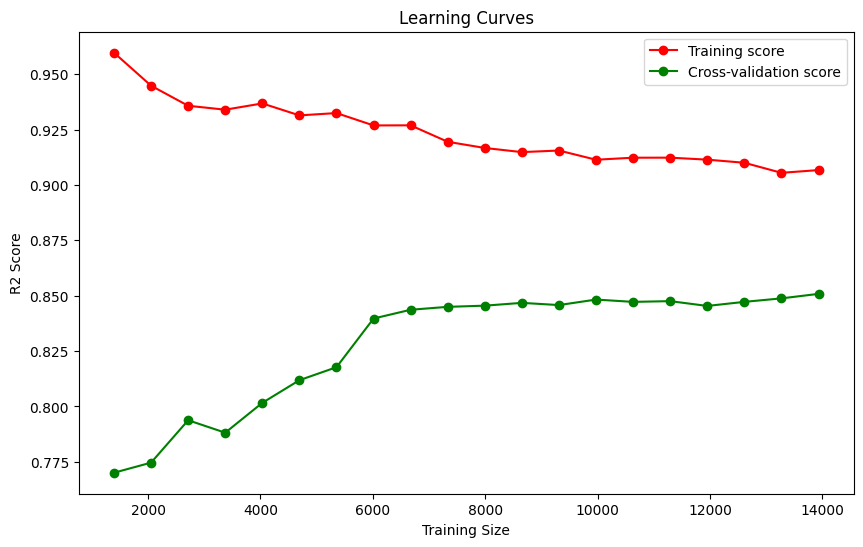

In [ ]:
# Plot learning curves
plt.figure(figsize=(10, 6))
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# Add labels and title
plt.xlabel("Training Size")
plt.ylabel("R2 Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

### 05 Exporting the pipeline as a pickle 🥒

In [ ]:
# breakpoint()

In [ ]:
import pickle

# export pipe as pickle file
with open('pipeline/pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline_tuned, file)

In [ ]:
# load pickle back into test
pipe = pickle.load(open('pipeline/pipeline.pkl', 'rb'))

In [ ]:
y_pred = pipe.predict(X_test)

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Select a random sample of rows without specifying random_state
random_sample = results_df.sample(20)

# Calculate percentage difference and add a new column
random_sample['Percentage Difference'] = abs((random_sample['Predicted'] - random_sample['Actual']) / random_sample['Actual']) * 100

# Rearrange columns to place 'Actual', 'Predicted', and 'Percentage Difference' at the end
columns_order = [col for col in random_sample.columns if col not in ['Actual', 'Predicted', 'Percentage Difference']] + ['Actual', 'Predicted', 'Percentage Difference']
random_sample = random_sample[columns_order]

# Display the selected sample along with the corresponding features from X_test
results = pd.concat([random_sample, X_test.loc[random_sample.index]], axis=1).sort_values('Percentage Difference')

# Display the selected sample along with the corresponding features from X_test with styling
(pd.concat([random_sample, X_test.loc[random_sample.index]], axis=1)
 .sort_values('Percentage Difference')
 .style.applymap(lambda val: 'color: red' if val > 50 else 'color: grey', subset=['Percentage Difference']))

,Actual,Predicted,Percentage Difference,building_typology,building_gfa,primary_gfa,secondary_typology,secondary_gfa,year_built,occupancy,num_buildings
25707,310368.600000,311442.880644,0.346131,residential,71639,71639.000000,residential,71639.000000,1930,100,1
33627,245686.400000,251763.961462,2.473707,residential,56634,113268.000000,residential,113268.000000,1910,100,1
17714,291444.800000,280943.414301,3.603216,residential,60901,60901.000000,residential,60901.000000,1909,100,1
9471,975507.100000,897733.470588,7.972636,residential,153035,148080.000000,parking,10200.000000,1965,100,1
29149,15977996.800000,14670065.602040,8.185827,hospital,421234,421234.000000,data_center,1500.000000,1943,100,6
2184,290743.600000,343005.850139,17.975374,residential,87297,87297.000000,residential,87297.000000,1931,100,1
10146,1272529.100000,1527384.711547,20.027488,residential,181278,181278.000000,residential,181278.000000,1979,100,1
24316,171157.000000,218597.272464,27.717401,residential,41757,41757.000000,residential,41757.000000,1917,100,1
19546,379966.400000,265873.273347,30.027162,residential,43772,43772.000000,residential,43772.000000,1900,100,1
6678,17817448.300000,11685152.383569,34.417363,laboratory,360423,360423.000000,laboratory,360423.000000,2006,100,1
